In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import yfinance as yf
import pandas_datareader as pdr
from pandas.tseries.offsets import DateOffset

import re

pd.options.display.max_rows
pd.set_option('display.max_colwidth', -1)

<ipython-input-1-8b6b248af5bf>:13: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


## Clinical Trial Dataset: 

In [2]:
#get the Clinical Trial for COVID Data
covid = pd.read_csv("20210412020005_covid-19.tsv" ,sep='\t')

industry=covid[covid['funded_bys'].str.find('Industry')>-1]

industry_covid=pd.melt(industry, id_vars=['nct_id', 'other_ids', 'status','why_stopped', 'funded_bys', 'sponsor_collaborators','study_type', 'phases', 'conditions', 'keywords',
       'interventions', 'intervention_details', 'arm_details', 'outcome_measures', 'start_date','primary_completion_date', 'completion_date', 'first_posted',
       'results_first_posted', 'last_update_posted', 'nlm_download_date','study_first_submitted_date', 'has_expanded_access',
       'is_fda_regulated_drug', 'is_fda_regulated_device','is_unapproved_device', 'locations', 'number_of_facilities',
       'has_us_facility', 'has_single_facility'], value_vars=['lead_sponsor', 'collaborators'], value_name='company')
#seperate them 
industry_covid['explode']=industry_covid.company.str.replace(',', '').str.split('|')
#filter out the industry
industry_covid=industry_covid.explode(column='explode')
industry_covid=industry_covid[industry_covid['explode'].str.find('Industry')>-1]
industry_covid['industry_name']=industry_covid['explode'].str.extract(r'(.*)\[Industry\]')

industry_covid['filter_name']=industry_covid['industry_name'].str.lower().str.replace(' ag', '')
industry_covid['filter_name']=industry_covid['filter_name'].str.replace('.', '').str.replace(' inc', '',)
industry_covid['filter_name']=industry_covid['filter_name'].str.replace(' holdings', '')
industry_covid['filter_name']=industry_covid['filter_name'].str.replace(' llc', '')
industry_covid['filter_name']=industry_covid['filter_name'].str.replace(' corporation', '').str.replace(' corp', '').str.replace(' co\.', '')
industry_covid['filter_name']=industry_covid['filter_name'].str.replace(' se', '').str.replace(' ltd', '')

industry_covid=industry_covid.reset_index()
industry_covid['merge_name']=industry_covid['filter_name'].astype(str).str.extract(r'(^[\d\w\-\&\.]* ?[\w\-\&]{1,4})')

## Nasdaq Dataset:

In [3]:
#get the data
nasdaq=pd.read_csv('nasdaq_stocks.csv')

sectors=['Health Care']
health_stocks=nasdaq[nasdaq.Sector.isin(sectors)]

#remove any stocks that has no market cap
health_stocks=health_stocks[health_stocks['Market Cap']>1]

#get stock name of the company ( first word and two letter of the second word)

health_stocks['merge_name']=health_stocks['Name'].str.lower().str.replace(' american depositary shares', '')
health_stocks['merge_name']=health_stocks['merge_name'].str.replace('common stock', '')
health_stocks['merge_name']=health_stocks['merge_name'].str.replace(' inc.', '')\
                                    .str.replace('corporation', '').str.replace('corp', '').str.replace('se ', '').str.replace('.', '')
health_stocks['merge_name']=health_stocks.merge_name.str.extract(r'(^[\w\-\&\.]* ?[\w\-\&]{1,4})')

health_stocks.rename(columns={'Name':'Stock_Name', 'Symbol':'Stock_Symbol'}, inplace=True)
health_stocks=health_stocks.reset_index()

#count words that were extracted
industry_covid['merge_name']=industry_covid['merge_name'].str.rstrip(' ')
industry_covid['number_words']=industry_covid['merge_name'].str.count(' ')+1

health_stocks['merge_name']=health_stocks['merge_name'].str.rstrip(' ')
health_stocks['number_words']=health_stocks['merge_name'].str.count(' ')+1

#break up df with the number of words
industry_1=industry_covid[industry_covid['number_words']==1]
industry_2=industry_covid[industry_covid['number_words']==2]

stocks_1=health_stocks[health_stocks['number_words']==1]
stocks_2=health_stocks[health_stocks['number_words']==2]

## Merging Clinical Trials and Nasdaq Datasets: 

### Merge: Step1 and Step 2

In [4]:
#Merge the names of the stocks and clinical trials using two words
outer2_2=industry_2.merge(stocks_2, on='merge_name', how='outer')
inner2_2=industry_2.merge(stocks_2, on='merge_name', how='inner')

#Merge the names of the stocks and clinical trials using one words
outer1_1=industry_1.merge(stocks_1, on='merge_name', how='outer')
inner1_1=industry_1.merge(stocks_1, on='merge_name', how='inner')

### Merge: Step3 and Step 4

In [5]:
col_industry=['nct_id', 'other_ids', 'status', 'why_stopped', 'funded_bys',
       'sponsor_collaborators','study_type',
       'phases', 'conditions', 'keywords', 'interventions',
       'intervention_details', 'arm_details', 'outcome_measures', 'start_date',
       'primary_completion_date', 'completion_date', 'first_posted',
       'results_first_posted', 'last_update_posted', 'nlm_download_date',
       'study_first_submitted_date', 'has_expanded_access',
       'is_fda_regulated_drug', 'is_fda_regulated_device',
       'is_unapproved_device', 'locations', 'number_of_facilities',
       'has_us_facility', 'has_single_facility', 'company', 'explode', 'merge_name']
col_stocks=['merge_name','Stock_Symbol', 'Stock_Name', 'Last Sale',
       'Net Change', '% Change', 'Market Cap', 'Country', 'IPO Year', 'Volume',
       'Sector', 'Industry']


#industries witout corresponding stocks
industry_2_wo_stocks=outer2_2[outer2_2.Stock_Symbol.isna()][col_industry]
industry_1_wo_stock=outer1_1[outer1_1['Stock_Name'].isna()][col_industry]

#stocks without corresponding industries
stocks_2_wo_industry=outer2_2[outer2_2.company.isna()][col_stocks]
stocks_1_wo_industry=outer1_1[outer1_1['company'].isna()][col_stocks]

#Extracting one-word names from the unmerged two word name companies. 
stocks_2_wo_industry['word']=stocks_2_wo_industry.merge_name.str.extract(r'(^[\w\-\&]*)\s')
industry_2_wo_stocks['word']=industry_2_wo_stocks.merge_name.str.extract(r'(^[\w\-\&]*)\s')

#Prepare columns for merge
industry_1_wo_stock['word']=industry_1_wo_stock['merge_name']
stocks_1_wo_industry['word']=stocks_1_wo_industry['merge_name']

#Actual Step3 and Step 4 merge
industry1_stocks_2=industry_1_wo_stock.merge(stocks_2_wo_industry, on='word', how='inner')
industry2_stocks1=industry_2_wo_stocks.merge(stocks_1_wo_industry, on='word', how='inner')
industry2_stocks1=industry2_stocks1[industry2_stocks1.Stock_Symbol!='NATR']

### Merge: Step5

In [6]:
#Need to add in Johnson & Jonhson, it's under the name Janssen
#use one word to merge Jassen to Johnson Johnson
johnson_and_johnson=industry_2[industry_2.merge_name.str.find('janssen')>-1]
johnson_and_johnson['merge_name']=johnson_and_johnson['merge_name'].str.extract(r'(^\w*)\s')
johnson_and_johnson[col_industry]
johnson_and_johnson=johnson_and_johnson.reset_index()

jnj_stock=health_stocks[health_stocks.Stock_Symbol=='JNJ']
jnj_df=jnj_stock.append(jnj_stock).append(jnj_stock).append(jnj_stock).append(jnj_stock).append(jnj_stock).append(jnj_stock).append(jnj_stock).append(jnj_stock).append(jnj_stock).append(jnj_stock)
jnj_df=jnj_df[['Stock_Symbol', 'Stock_Name', 'Last Sale', 'Net Change',
       '% Change', 'Market Cap', 'Country', 'IPO Year', 'Volume', 'Sector',
       'Industry', 'merge_name',]]

jnj_df=jnj_df.reset_index()
johnson_df=johnson_and_johnson.merge(jnj_df, left_index=True, right_index=True, how='outer')

<ipython-input-6-18fead4ef2c4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  johnson_and_johnson['merge_name']=johnson_and_johnson['merge_name'].str.extract(r'(^\w*)\s')


### Merging all the Five of the Dataframes together

In [7]:
#Ensure all the columns match before stacking them 

col_final_merge=['nct_id', 'other_ids', 'status', 'why_stopped', 'funded_bys','study_type',
       'phases', 'conditions', 'keywords', 'interventions',
       'intervention_details', 'arm_details', 'outcome_measures', 'start_date',
       'primary_completion_date', 'completion_date', 'first_posted',
       'results_first_posted', 'last_update_posted', 'nlm_download_date',
       'study_first_submitted_date', 'has_expanded_access',
       'is_fda_regulated_drug', 'is_fda_regulated_device',
       'is_unapproved_device', 'locations', 'number_of_facilities',
       'has_us_facility', 'has_single_facility', 'explode', 'merge_name', 'Stock_Symbol', 'Stock_Name', 'Last Sale',
       'Net Change', '% Change', 'Market Cap', 'Country', 'IPO Year', 'Volume',
       'Sector', 'Industry']

industry1_stocks_2.rename(columns={'merge_name_x':'merge_name'}, inplace=True)
industry2_stocks1.rename(columns={'merge_name_x':'merge_name'}, inplace=True)

industry1_stocks_2=industry1_stocks_2[col_final_merge]
industry2_stocks1=industry2_stocks1[col_final_merge]

inner2_2=inner2_2[col_final_merge]
inner1_1=inner1_1[col_final_merge]

clinicalstocks=pd.concat([industry1_stocks_2, inner2_2, inner1_1, industry2_stocks1,johnson_df])

#converting all the date strings to datatime
clinicalstocks['start_date']=pd.to_datetime(clinicalstocks['start_date'])
clinicalstocks['primary_completion_date']=pd.to_datetime(clinicalstocks['primary_completion_date'])
clinicalstocks['completion_date']=pd.to_datetime(clinicalstocks['completion_date'])
clinicalstocks['first_posted']=pd.to_datetime(clinicalstocks['first_posted'])
clinicalstocks['results_first_posted']=pd.to_datetime(clinicalstocks['results_first_posted'])

In [8]:
df=clinicalstocks

## Question1: Does clinical trial numbers, clinical treatment,  and phrases impact the stock performance?


### Getting the Drug Name for Each Clinical Trial:

In [25]:
def change_placebo(dataframe):
    import re
    if dataframe['treatment']=="Placebo":
        dataframe['treatment']=dataframe['interventions'].split(':')[-1]
    else:
        dataframe['treatment']=dataframe['treatment']
    return dataframe


def change_specific_treatments(row):
    if row =='':
        return 'FP-R01-MG-F2'
    elif row=='0.9':
        return 'AZD1222'
    elif row=='1':
        return 'CoV2SAM(LNP)'
    elif row=='100':
        return 'Virazole'
    elif row=='50': 
        return 'Virazole'
    elif row=='BGB': 
        return 'BGB-DXP593'
    elif row=='COVID-19': 
        return 'Spike-GM-CSF'
    elif row=='Cliniporator': 
        return 'CORVax'
    elif row=='Group': 
        return 'HCQ'
    elif row=='High': 
        return 'Radiation'
    elif row=='ISIS': 
        return 'ISIS-721744'
    elif row=='Interferon': 
        return 'Remdesivir'
    elif row=='Longeveron': 
        return 'LMSC'
    elif row=='Marker': 
        return 'D2000'
    elif row=='Nitric': 
        return 'iNO'
    elif row=='No': 
        return 'None'
    elif row=='Part': 
        return 'Upamostat'
    elif row=='Pegylated': 
        return 'Peginterferon'
    elif row=='Placebos': 
        return 'Azithromycin'
    elif row=='Recombinant': 
        return 'Rintatolimod'
    elif row=='Routine': 
        return 'None'
    elif row=='Saline': 
        return 'Ampion'
    elif row=='Self': 
        return 'KB109'
    elif row=='Sodium': 
        return 'SAM-LNP'
    elif row=='To': 
        return 'Ad26.COV2.S'
    elif row=='Trans': 
        return 'TSC'
    elif row=='draw': 
        return 'blood'
    elif row=='RDV':
        return 'remdesivir'
    elif row=='Remdesivir (RDV)':
        return 'remdesivir'
    elif row=='REGN10933 + REGN10987':
        return 'REGN10933/REGN10987'
    elif row=='REGN10933+REGN10987 combination therapy':
        return 'REGN10933/REGN10987'    
    else:
        return row

    
def change_selected_cells(dataframe, index_newcell, column):
    '''With the zip lists, change the find selected index and selected column, to the desired new values'''
    for index, v in index_newcell.items():
        dataframe.loc[index, column]=v
    return dataframe


q1=df.copy()

#Getting treatment names from intervention
q1['treatment']=q1['intervention_details'].str.extract(r'^[\w]*:([\w\-\.]*)')

#Some names of the drugs were not extracted properly
q1['treatment']=q1.treatment.apply(change_specific_treatments)
q1=q1.apply(change_placebo, axis=1)
q1['treatment']=q1['treatment'].str.strip(' ')

change_treatment_index=[39, 82, 163, 165, 295, 304]
change_treatments=['otilimab','remdesivir','ampion','SOC','gammaCore','sirukumab']
change_index_treatments=dict(zip(change_treatment_index, change_treatments))
q1=q1.reset_index()
q1=change_selected_cells(q1,  change_index_treatments, 'treatment')

### Get Nature of the Treatment:

In [26]:
def detail_treatments_func(df):
    """kdkjfkdj"""
#other biologics: enzymes, antibotic, steroids, heparin
#biologics: antiviral, antibodies

    #anything with 'mab' is antibody
    import re
    if re.match(r'.+mab$', str(df['treatment']).lower()):
        df['detail_treatment']='antibody'
        
    ###find all the vaccines
    elif re.match(r'vaccine', str(df['keywords']).lower()):
        df['detail_treatment']='vaccine'
    elif re.match(r'vaccine', str(df['treatment']).lower()):
        df['detail_treatment']='vaccine'
    elif re.match(r'.+cine', str(df['intervention_details']).lower()):
        df['detail_treatment']='vaccine'
    elif re.match(r'.+vac', str(df['treatment']).lower()):
        df['detail_treatment']='vaccine'
    elif re.match(r'.+vax', str(df['treatment']).lower()):
        df['detail_treatment']='vaccine'
                                   
    #antiviral
    elif re.match(r'.+vir$', str(df['treatment']).lower()):
        df['detail_treatment']='antiviral'
                                   
    #small molecule drugs
    elif re.match(r'.+oral.+', str(df['intervention_details']).lower()):
        df['detail_treatment']='small molecule drugs'                                   
    elif re.match(r' po ', str(df['intervention_details']).lower()):
        df['detail_treatment']='small molecule drugs'
    elif re.match(r'.+nib$', str(df['treatment']).lower()):
        df['detail_treatment']='small molecule drugs'
    elif re.match(r'.olone$', str(df['treatment']).lower()):
        df['detail_treatment']='small molecule drugs'
    elif re.match(r'\w+\-\d+', str(df['treatment']).strip(' ').lower()):
        df['detail_treatment']='small molecule drugs'
    elif re.match(r'\w+\d+', str(df['treatment']).strip(' ').lower()):
        df['detail_treatment']='small molecule drugs'
    return df

q1['detail_treatment']=None
q1=q1.apply(detail_treatments_func, axis=1)

### Change Clinical Trial Phases to Numberical:

In [29]:
columns=['nct_id', 'status', 'study_type', 'phases','keywords', 'interventions', 'intervention_details','start_date',
         'primary_completion_date', 'completion_date','results_first_posted', 'is_fda_regulated_drug', 
         'is_fda_regulated_device','is_unapproved_device', 'locations', 'Country','merge_name','Stock_Symbol', 'Stock_Name', 'treatment',
       'detail_treatment']
active_status=['Active, not recruiting', 'Completed', 'Not yet recruiting','No longer available', 'Recruiting', 'Available',
               'Approved for marketing', 'Enrolling by invitation']


def phases_function(row):
    if (row=='Phase 1') | (row=='Early Phase 1'):
        return 1
    elif row=='Phase 1|Phase 2':
        return 1.5
    elif row=='Phase 2':
        return 2
    elif row=='Phase 2|Phase 3':
        return 2.5
    elif row=='Phase 3':
        return 3
    elif row=='Phase 4':
        return 4
    
    
def completed_trials(df):
    '''if drugs is ready to market, then it's 1 or else it's 0'''
    if (df['phases_no']==3) & (df['status']=='Completed'):
        df['market_drug']=1
    else: 
        df['market_drug']=0
    return df


#only want the active/ already in market clinical trials:
q1=q1[q1.status.isin(active_status)][columns]


#discard all the phases without phases and get phases of each drug
q1=q1[~q1.phases.isna()]
q1['phases_no']=q1['phases'].map(phases_function)
q1=q1.apply(completed_trials, axis=1)

### Does the number of Clinical Trials impact the stocks?

In [30]:
def change_in_price(df):
    try:
        prices=pdr.get_data_yahoo(df['Stock_Symbol'], start=df['2wks_before'], end=df['2wks_after'])
        prices['daily_average']=(prices['High']+prices['Low'])/2
        value=((prices.iloc[-1]['daily_average']-prices.iloc[0]['daily_average'])/prices.iloc[0]['daily_average'])*100
        df['percentage']=value
    except:
        df['percentage']=None
    return df

#interested in stock prices two weeks before the clinical trial started and two weeks after clinical started
q1_num=q1.groupby('Stock_Symbol').agg({'treatment': len, 'start_date':(min, max)}).reset_index().droplevel(0, axis=1)
q1_num=q1_num.rename(columns={'':'Stock_Symbol','min':'start_date_min', 'max':'start_date_max'})

q1_num['2wks_before']=q1_num.start_date_min-DateOffset(weeks=2)
q1_num['2wks_after']=q1_num.start_date_max+DateOffset(weeks=2)

#use Yahoo Finance to get change stock price from two weeks before 'start_date' and two weeks after "start_date"
q1_num_price=q1_num.apply(change_in_price, axis=1)
q1_num_price

,Stock_Symbol,len,start_date_min,start_date_max,2wks_before,2wks_after,percentage
0,ABBV,4,2020-03-18,2020-12-10,2020-03-04,2020-12-24,13.926221
1,ABIO,1,2020-12-10,2020-12-10,2020-11-26,2020-12-24,-0.462963
2,ADMP,1,2021-05-01,2021-05-01,2021-04-17,2021-05-15,-1.418443
3,AEMD,1,2021-01-31,2021-01-31,2021-01-17,2021-02-14,10.526320
4,AIM,1,2020-09-04,2020-09-04,2020-08-21,2020-09-18,-15.734990
...,...,...,...,...,...,...,...
110,VSTM,2,2020-10-12,2020-11-18,2020-09-28,2020-12-02,61.176479
111,VTGN,1,2020-11-30,2020-11-30,2020-11-16,2020-12-14,2.068968
112,VXRT,1,2020-09-21,2020-09-21,2020-09-07,2020-10-05,30.057253
113,WINT,1,2020-11-02,2020-11-02,2020-10-19,2020-11-16,-4.263007


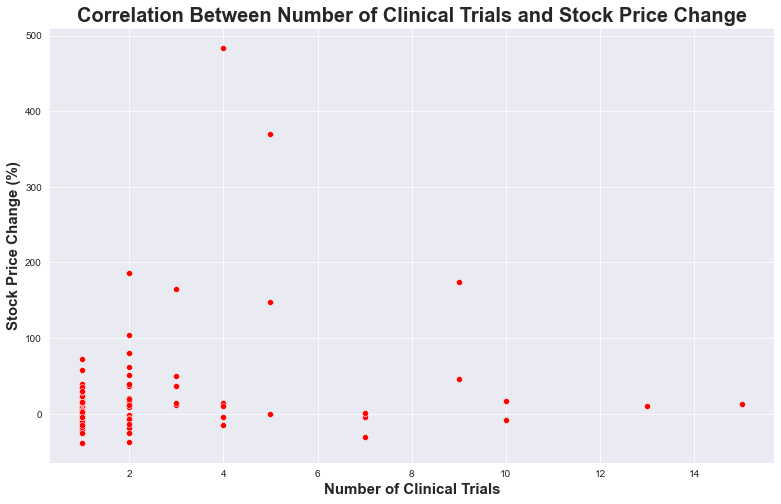

In [31]:
def plot_single(data, x, y, x_name, y_name, title): 
    plt.figure(figsize=(13,8))
    sns.color_palette("Set2")
    sns.set_style('darkgrid')
    sns.scatterplot(x = x, y = y, data = data, color='r')
    
    plt.xlabel(x_name, fontdict={'fontsize': 15, 'weight':'bold'})
    plt.ylabel(y_name, fontdict={'fontsize': 15, 'weight':'bold'})
    plt.title(title, fontdict={'fontsize': 20, 'weight':'bold'})

    
plot_single(q1_num_price, "len", 'percentage', 'Number of Clinical Trials', 'Stock Price Change (%)', \
            "Correlation Between Number of Clinical Trials and Stock Price Change")

### Figure1.1 The Number of Clinical Trials vs Price Change of Stocks:

Here we explore the whether the company with more COVID-19 clinical trials will have a bigger price change in their stock price. Our result that companies with more clinical trials did not correlate with a higher stock change. 

### How does clinical trial entering the different phases impact company stock price?

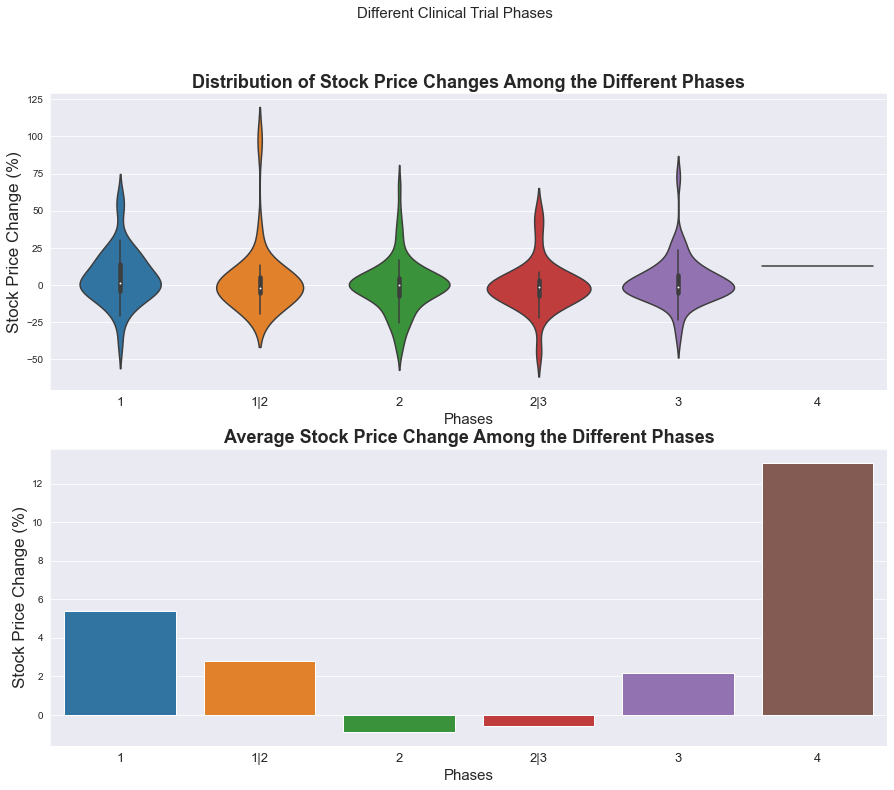

In [32]:
q1_phase=q1.copy()
q1_phase['2wks_before']=q1_phase.start_date-DateOffset(weeks=2)
q1_phase['2wks_after']=q1_phase.start_date+DateOffset(weeks=2)

q1_phase_price=q1_phase.apply(change_in_price, axis=1)
q1_phase_mean=q1_phase_price.groupby(['phases_no'])['percentage'].mean()

fig, ax=plt.subplots(2, figsize=(15,12))
sns.violinplot(x="phases_no", y="percentage", data=q1_phase_price, ax=ax[0])
ax[0].set_xticklabels(['1','1|2','2','2|3','3', '4'], fontsize=13)
ax[0].set_xlabel("Phases", fontsize=15)
ax[0].set_title('Distribution of Stock Price Changes Among the Different Phases', fontdict={'fontsize': 18, 'fontweight':'bold'})
ax[0].set_ylabel('Stock Price Change (%)', fontsize=17);

sns.barplot(x=q1_phase_mean.index, y=q1_phase_mean, ax=ax[1])
ax[1].set_xticklabels(['1','1|2','2','2|3','3', '4'], fontsize=13)
ax[1].set_title('Average Stock Price Change Among the Different Phases', fontdict={'fontsize': 18, 'fontweight':'bold'})
ax[1].set_xlabel("Phases", fontsize=15)
plt.suptitle('Different Clinical Trial Phases', fontsize=15, fontweight=10)
ax[1].set_ylabel('Stock Price Change (%)', fontsize=17);

### Does the type of treatment impact the stock price change?

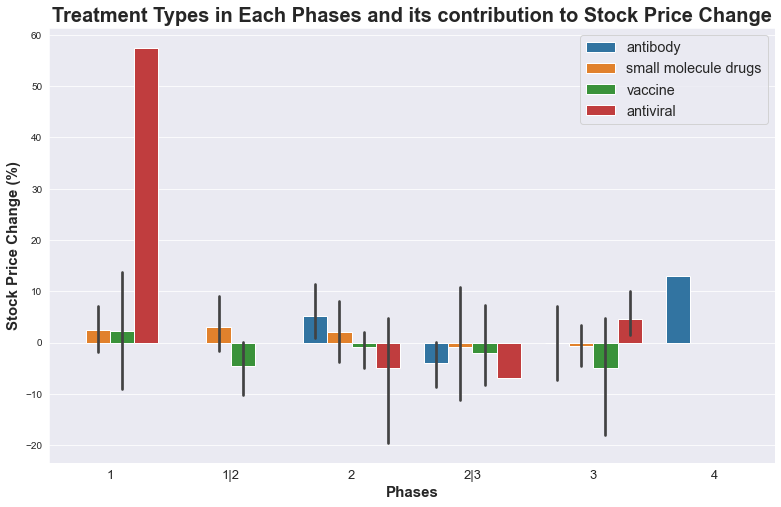

In [33]:
fig, ax=plt.subplots(1, figsize=(13,8))
sns.barplot(x="phases_no", y="percentage", hue='detail_treatment', data=q1_phase_price, ax=ax)
sns.color_palette("Set2")
sns.set_style('darkgrid')

ax.set_xlabel('Phases', fontdict={'fontsize': 15, 'weight':'bold'})
ax.set_ylabel('Stock Price Change (%)', fontdict={'fontsize': 15, 'weight':'bold'})
ax.set_title('Treatment Types in Each Phases and its contribution to Stock Price Change', fontdict={'fontsize': 20, 'weight':'bold'})
ax.set_xticklabels(['1','1|2','2','2|3','3', '4'], fontsize=13)
plt.legend(fontsize='x-large', loc=1)

In [ ]:
# Impact of stock prices of Companes################ 

In [34]:
q3=q1.copy()
q3=q3.groupby(['Stock_Symbol','treatment','Country'])[['start_date']].min().reset_index()

In [35]:
q3['2wks_before']=q3.start_date-DateOffset(weeks=2)
q3['2wks_after']=q3.start_date+DateOffset(weeks=2)

q3_df=q3.apply(change_in_price, axis=1)

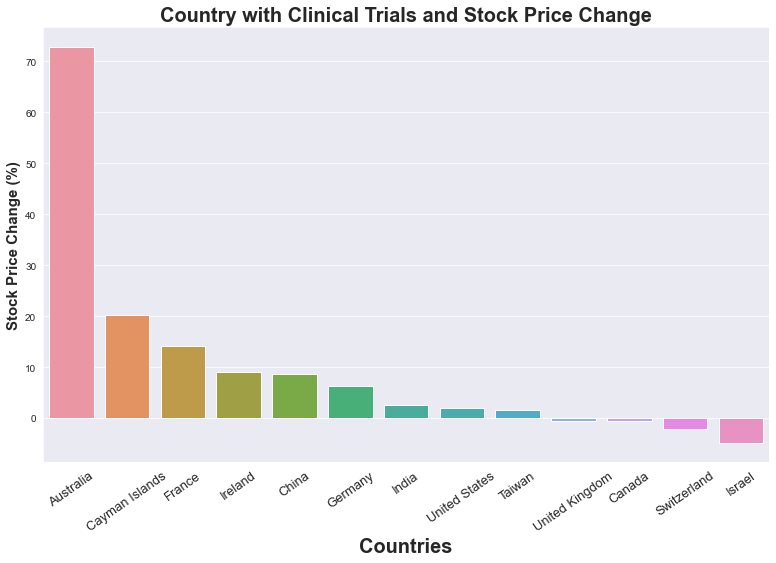

In [36]:
q3_country=q3_df.groupby(['Country'])['percentage'].mean().sort_values(ascending=False)
fig, ax=plt.subplots(1, figsize=(13,8))
sns.barplot(x=q3_country.index, y=q3_country,  ax=ax)
sns.color_palette("Set2")
sns.set_style('darkgrid')

ax.set_xlabel('Countries', fontdict={'fontsize': 20, 'weight':'bold'})
ax.set_ylabel('Stock Price Change (%)', fontdict={'fontsize': 15, 'weight':'bold'})
ax.set_title('Country with Clinical Trials and Stock Price Change', fontdict={'fontsize': 20, 'weight':'bold'})
ax.set_xticklabels(q3_country.index, rotation=35, fontsize=13);

In [72]:
q3b=q1.copy()
q3b['extract_country']=q3b.locations.str.replace(',','').str.split('|')
q3b=q3b.explode('extract_country')
q3b['extract_country']=q3b.extract_country.str.extract(r'.+\s(\w+$)')
q3b=q3b.groupby(['nct_id','Stock_Symbol','extract_country','start_date'])[['status']].count().rename(columns={'status':'count'}).reset_index()
qb3=q3b.groupby(['Stock_Symbol', 'start_date'])[['extract_country']].count().reset_index().sort_values('extract_country',ascending=False)

In [ ]:
q3b['2wks_before']=q3b.start_date-DateOffset(weeks=2)
q3b['2wks_after']=q3b.start_date+DateOffset(weeks=2)

q3b_df=q3b.apply(change_in_price, axis=1)

In [41]:
q3b_df

nct_id  \
0    NCT04327388   
2    NCT04469621   
3    NCT04315298   
4    NCT04315896   
5    NCT04318015   
..           ...   
309  NCT04614948   
310  NCT04765384   
312  NCT04375397   
313  NCT04439006   
314  NCT04838795   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         